In [308]:
# 자체구현 nn library로 xor 학습시키기
import math
import random
import numpy as np


learning_rate = 0.1
momentum_rate = 0.2
dropout_rate = 0.2
weight_decay_rate = 0.0
use_relu = False


# xor
xx = [(1, 0), (0, 1), (1, 1), (0, 0)]
yy  = [1, 1, 0, 0]
train_set = zip(xx, yy)

def sig(x):
    if use_relu is False:
        return 1.0 / (1 + math.exp(-x))
    
    if x > 0:
        return x
    # import pudb; pudb.set_trace()  # NOQA  # pylint: disable=multiple-statements
    return 0


def prime_sig(x):
    if use_relu is False:
        return sig(x) * (1.0 - sig(x))
    
    if x > 0:
        return 1
    return 0


def cost(y, a):
    return (y - a) * (y - a)


def gradient_cost(y, a):
    return 2 * (a - y)

class Node:
    def __init__(self, batch_size=10):
        self.v = [-1.0 for _ in range(batch_size)]  # value (= output)
        self.p = [0.0 for _ in range(batch_size)]  # prime value
        self.drop = [False for _ in range(batch_size)]  # dropout


class Layer:
    def __init__(self, node_cnt):
        self.node_cnt = -1
        self.nodes = []
        self.node_cnt = node_cnt
        for i in range(node_cnt):
            self.nodes.append(Node())


class NN:
    def __init__(self, input_layer_node_cnt):
        self.layers = []
        self.layers.append(Layer(input_layer_node_cnt))
        self.weights = [[]]
        self.bias = [[]]
        self.pv_cost = 10000000000
        self.online = False
        self.dropout = False

    def add_layer(self, node_cnt, default_weight=0.5):
        assert len(self.layers) > 0
        pl = self.layers[len(self.layers) - 1]
        self.layers.append(Layer(node_cnt))
        nl = self.layers[len(self.layers) - 1]
        ws = [[] for _ in range(len(nl.nodes))]
        for i in range(len(ws)):
            # ws[i] = [default_weight for _ in range(len(pl.nodes))]
            # ws[i] = [(random.random() * 0.5) * 2.0 for _ in range(len(pl.nodes))]
            if use_relu is True:
                ws[i] = [(random.random() * 0.5) * 2.0 for _ in range(len(pl.nodes))]
            else:
                ws[i] = [(random.random() - 0.5) * 2.0 for _ in range(len(pl.nodes))]
        self.weights.append(ws)
        if use_relu is True:
            self.bias.append([0 for _ in range(len(nl.nodes))])
        else:
            self.bias.append([(random.random() - 0.5) * 2.0 for _ in range(len(nl.nodes))])
        # self.bias.append([0 for _ in range(len(nl.nodes))])

    # change p-value of final layer's nodes to p-value * cost gradient
    def _multiply_cost_gradient_to_last_layer(self, batch_index, x, y):
        fl = self.layers[-1]
        for n in fl.nodes:
            # gradient_cost can be interpreted as error_rate
            error_rate = gradient_cost(y, n.v[batch_index])
            n.p[batch_index] *= error_rate
            
    def _backword(self, batch_set):  # backpropagation
        # update p-values
        for i in range(len(self.layers) - 1):
            li = -(i + 1)
            ll = self.layers[li - 1]
            rl = self.layers[li]
            ws = self.weights[li]
            for bi in range(len(batch_set)):
                for fr in range(len(ll.nodes)):
                    if ll.nodes[fr].drop[bi] is True: continue
                    error_rate_sum = 0  # sum over all nodes
                    for to in range(len(rl.nodes)):
                        if rl.nodes[to].drop[bi] is True: continue
                        rp = rl.nodes[to].p[bi]
                        error_rate_sum += ws[to][fr] * rp
                    ll.nodes[fr].p[bi] *= error_rate_sum

        # update w and b
        for i in range(len(self.layers) - 1):
            li = -(i + 1)
            ll = self.layers[li - 1]
            rl = self.layers[li]
            ws = self.weights[li]
            #print('ws before:{}'.format(ws))
            for fr in range(len(ll.nodes)):
                if ll.nodes[fr].drop[bi] is True: continue
                for to in range(len(rl.nodes)):
                    if rl.nodes[to].drop[bi] is True: continue
                    delta_nabla_w = 0
                    for bi in range(len(batch_set)):
                        lv = ll.nodes[fr].v[bi]
                        rp = rl.nodes[to].p[bi]
                        delta_nabla_w += learning_rate * lv * rp\
                            + momentum_rate * delta_nabla_w
                    total_set_len = len(batch_set)  # FIXME should be fixed
                    ws[to][fr] = (1.0 - learning_rate * weight_decay_rate / total_set_len) * ws[to][fr] - delta_nabla_w / len(batch_set)
            for to in range(len(rl.nodes)):
                if rl.nodes[to].drop[bi] is True: continue
                delta_nabla_b = 0
                for bi in range(len(batch_set)):
                    rp = rl.nodes[to].p[bi]
                    delta_nabla_b += learning_rate * rp
                self.bias[li][to] -= delta_nabla_b / len(batch_set)
            #print('ws after:{}'.format(ws))

    def __forward(self, batch_index, flag_test=False):
        bi = batch_index
        for i in range(1, len(self.layers)):
            pl = self.layers[i - 1]
            nl = self.layers[i]
            for to in range(len(nl.nodes)):
                if nl.nodes[to].drop[bi] is True: continue
                sum = 0
                for fr in range(len(pl.nodes)):
                    if pl.nodes[fr].drop[bi] is True: continue
                    n = pl.nodes[fr].v[bi] * self.weights[i][to][fr]
                    if self.dropout and flag_test is True: n *= 1.0 - dropout_rate
                    sum += n
                sum += self.bias[i][to]
                nl.nodes[to].v[bi] = sig(sum)
                nl.nodes[to].p[bi] = prime_sig(sum)

    def _quadratic_weight_sum(self):
        sum = 0
        l1 = len(self.weights)
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                for k in range(len(self.weights[i][j])):
                    w = self.weights[i][j][k]
                    sum += w * w
        # n1 = np.linalg.norm(self.weights)**2
        # assert n1 == sum
        return sum

    def _forward(self, batch_set):
        if self.dropout is True:
            # except input and output layer
            for i in range(1, len(self.layers) - 1):
                l = self.layers[i]
                r = None
                while True:
                    r = list(np.random.binomial(1, 1.0 - dropout_rate, size=len(l.nodes)))
                    if r.count(1) > 0:
                        break

                print r
                for ix in range(len(l.nodes)):
                    for bi, (x, y) in enumerate(batch_set):
                        if r[ix] == 0:
                            l.nodes[ix].drop[bi] = True
                        else:
                            l.nodes[ix].drop[bi] = False

        c_sum = 0
        for bi, (x, y) in enumerate(batch_set):
            input_layer = self.layers[0]
            assert len(x) == len(input_layer.nodes)
            for i in range(len(input_layer.nodes)):
                input_layer.nodes[i].v[bi] = x[i]
            self.__forward(bi)
            fl = self.layers[-1]
            for n in fl.nodes:
                c_sum += cost(y, n.v[bi])
            if weight_decay_rate > 0:
                c_sum += weight_decay_rate * self._quadratic_weight_sum()
            self._multiply_cost_gradient_to_last_layer(bi, x, y)
        c_sum /= len(batch_set)
        print 'cost: {}'.format(c_sum)
        # assert c_sum <= self.pv_cost
        self.pv_cost = c_sum

    def train(self, batch_set, iter_cnt, **kwargs):
        if 'online' in kwargs:
            self.online = kwargs['online']
        if 'dropout' in kwargs:
            self.dropout = kwargs['dropout']

        print 'w before: {}'.format(self.weights)
        print 'b before: {}'.format(self.bias)
        for i in range(iter_cnt):
            if self.online:
                for sample in batch_set:
                    self._forward([sample])
                    self._backword([sample])
            else:
                self._forward(batch_set)
                self._backword(batch_set)

    def _test(self, x):
        self.__forward(0, True)
        fl = self.layers[-1]
        for i in range(len(fl.nodes)):
            a = fl.nodes[i].v[0]
            # print ('-=-=-=-= test output: %f' % a)
        return a  # temp

    def test(self, x):
        # print 'test..x:{}'.format(x)
        # print 'w:{}'.format(self.weights)
        # print 'b:{}'.format(self.bias)
        input_layer = self.layers[0]
        assert len(x) == len(input_layer.nodes)
        for i in range(len(input_layer.nodes)):
            input_layer.nodes[i].v[0] = x[i]
        return self._test(x)

nn = NN(len(train_set[0][0]))  # create nn with input layer of node cnt 2
nn.add_layer(2)  # add output layer
nn.add_layer(1)  # add output layer

# print y
# nn.weights = [[], [[3.021596611333707, 4.290557654426911], [2.4474747754313784, -3.9210233101531577]], [[4.050810152308848, 3.572852588982029]]]
# nn.bias = [[], [-0.3806880967531911, -2.1647667258035557], [-3.9489553245825983]]

# nn.weights = [[], [[-5.225214311691467, 5.064385339389469], [5.615326733242127, -5.496280445170741]], [[9.781277261289771, 9.747376824195413]]]
# nn.bias = [[], [-2.839650892910197, -3.2429109530089155], [-4.809422226730563]]

nn.train(train_set, 10000, online=False, dropout=False)  # train with train set(Y) and iteration cnt
for xxx in xx:
    print "-=-= test output: %f" % nn.test(xxx)
# nn.test([0.5, 0.2])
w = nn.weights
print nn.weights
print nn.bias


w before: [[], [[-0.13179000451898992, 0.7925229751894325], [-0.6198411988255006, 0.9493389746139158]], [[0.6202130403749782, 0.6413564841741075]]]
b before: [[], [0.022289716248710123, 0.3037642947047525], [-0.7618079156363882]]
cost: 0.252531135704
cost: 0.252544389177
cost: 0.25255898546
cost: 0.252574812891
cost: 0.252591766294
cost: 0.252609746652
cost: 0.252628660794
cost: 0.2526484211
cost: 0.252668945212
cost: 0.252690155763
cost: 0.252711980117
cost: 0.25273435012
cost: 0.252757201865
cost: 0.252780475467
cost: 0.252804114846
cost: 0.252828067523
cost: 0.252852284426
cost: 0.252876719706
cost: 0.252901330559
cost: 0.252926077059
cost: 0.252950921998
cost: 0.252975830739
cost: 0.253000771067
cost: 0.253025713055
cost: 0.253050628936
cost: 0.253075492977
cost: 0.253100281366
cost: 0.2531249721
cost: 0.253149544878
cost: 0.253173981006
cost: 0.2531982633
cost: 0.253222375998
cost: 0.253246304674
cost: 0.253270036162
cost: 0.253293558474
cost: 0.253316860734
cost: 0.253339933108
c

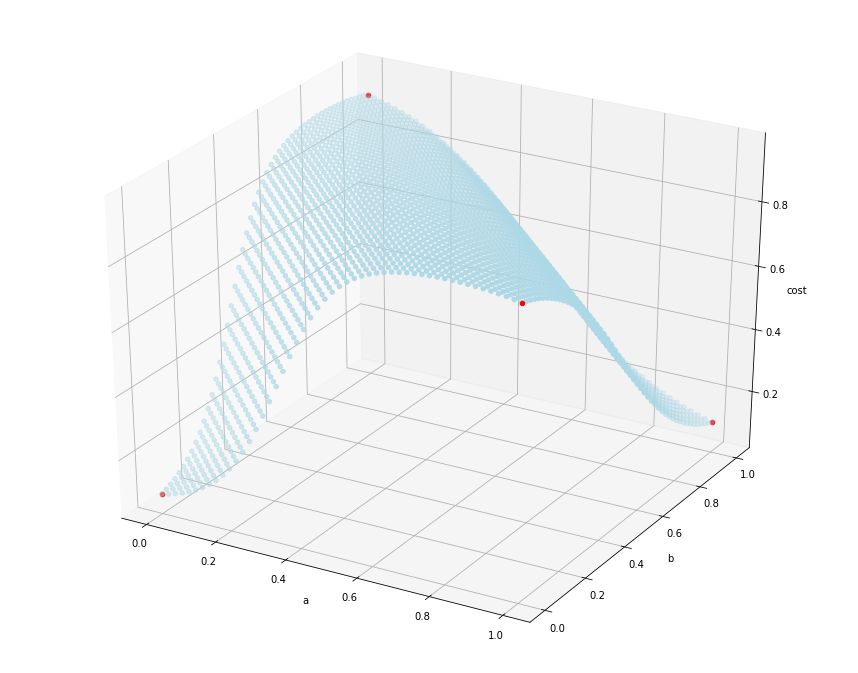

In [309]:
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
 
 
va = [];vb = [];vc = []
for aa in range(0,51):
    a = 1.0 * aa / 50
    for bb in range(0, 51):
        b = 1.0 * bb / 50
        c = nn.test([a,b])
        va.append(a);vb.append(b);vc.append(c)
ax.scatter(va, vb, vc, color='lightblue', depthshade=True)
ax.scatter([1], [0], [nn.test([1,0])], c='red', depthshade=False)
ax.scatter([0], [1], [nn.test([0,1])], c='red', depthshade=False)
ax.scatter([1], [1], [nn.test([1,1])], c='red', depthshade=False)
ax.scatter([0], [0], [nn.test([0,0])], c='red', depthshade=False)

# print vc
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('cost')
plt.show()


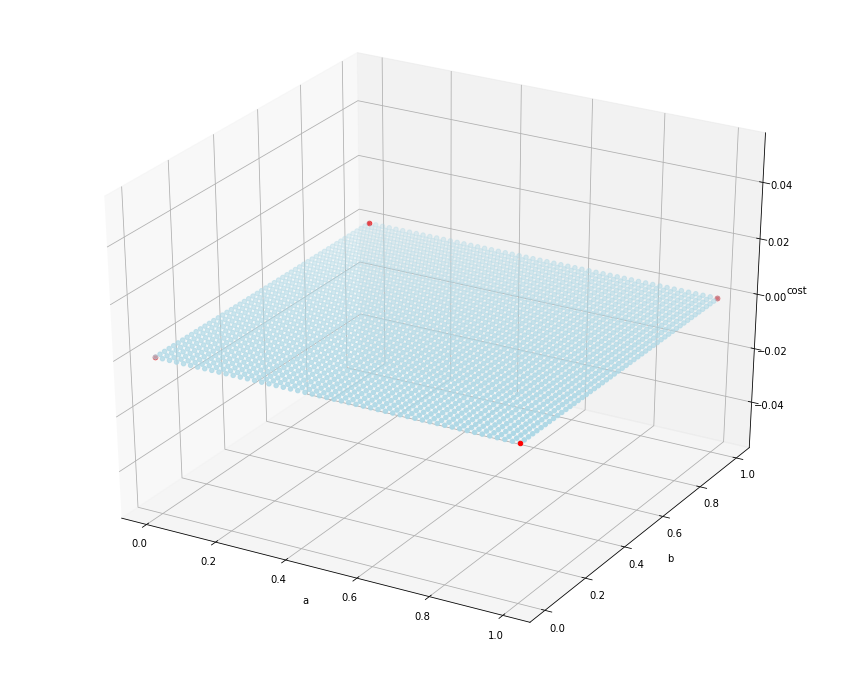

In [330]:
# 결국 학습시키고자 하는 파라미터는 W와 b들의 집합
# 학습이 완료된 W와B를 기억하고 있으면 더이상 학습은 필요없음


# sigmoid version으로 학습된 W, B
#use_relu = False
#nn.weights = [[], [[-5.225214311691467, 5.064385339389469], [5.615326733242127, -5.496280445170741]], [[9.781277261289771, 9.747376824195413]]]
#nn.bias = [[], [-2.839650892910197, -3.2429109530089155], [-4.809422226730563]]

# sigmoid version2
#use_relu = False
#nn.weights = [[], [[5.817244488874337, 5.922379111964924], [-2.3984613902173084, -2.4590775337421373]], [[8.22481155347087, 8.880033821411194]]]
#nn.bias = [[], [-2.186401206929418, 3.333432629549817], [-11.866707305939716]]

# relu version으로 학습된 W, B
#use_relu = True
#nn.weights = [[], [[-0.9206131543356578, 1.041771413413214], [0.4793289031375831, -0.49222446679543364]], [[1.0862325780274436, 2.1517713081040424]]]
#nn.bias = [[], [-0.07306781816077972, 0.009680964989456815], [-0.052237403615505884]]


#zero
use_relu = True
nn.weights = [[], [[0,0], [0, 0]], [[0, 0]]]
nn.bias = [[], [0, 0], [0]]


#ramdom
#use_relu = False
#nn.weights = [[], [[1,2], [-1, 7]], [[5, 7]]]
#nn.bias = [[], [-7, 10], [6]]

#random2
#use_relu = False
#nn.weights = [[], [[1,-10], [1, -10]], [[1, -10]]]
#nn.bias = [[], [1, 1], [1]]

#hand made 강의자료
#use_relu = False  # True도 가능
#nn.weights = [[], [[5,5], [-7, -7]], [[-11, -11]]]
#nn.bias = [[], [-8, 3], [6]]


import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
 
 
va = [];vb = [];vc = []
for aa in range(0,51):
    a = 1.0 * aa / 50
    for bb in range(0, 51):
        b = 1.0 * bb / 50
        c = nn.test([a,b])
        va.append(a);vb.append(b);vc.append(c)
ax.scatter(va, vb, vc, color='lightblue', depthshade=True)
ax.scatter([1], [0], [nn.test([1,0])], c='red', depthshade=False)
ax.scatter([0], [1], [nn.test([0,1])], c='red', depthshade=False)
ax.scatter([1], [1], [nn.test([1,1])], c='red', depthshade=False)
ax.scatter([0], [0], [nn.test([0,0])], c='red', depthshade=False)

# print vc
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('cost')
plt.show()



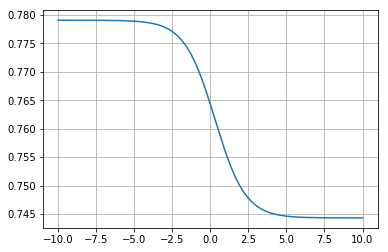

In [295]:
def get_vx(fr, to, jump):
    v = []
    while fr < to:
        v.append(fr)
        fr += jump
    return v

vx = []
vy = []
vx = get_vx(-10,10,0.1)


# sigmoid good model

nn.weights = [[], [[-5.225214311691467, 5.064385339389469], [5.615326733242127, -5.496280445170741]], [[9.781277261289771, 9.747376824195413]]]
nn.bias = [[], [-2.839650892910197, -3.2429109530089155], [-4.809422226730563]]


# random
nn.weights =  [[], [[-0.5165693483520402, 0.6381374990633439], [-0.5919999002100662, 0.2758633810748421]], [[0.8569660716811944, -0.19179130414197276]]]
nn.bias =  [[], [0.6160159801693461, -0.25006252942949336], [0.8104689775729195]]

for x in vx:
    nn.weights[1][1][0] = x
    vy.append(nn.test([1,0]))

plt.plot(vx, vy)
plt.grid()
plt.show()

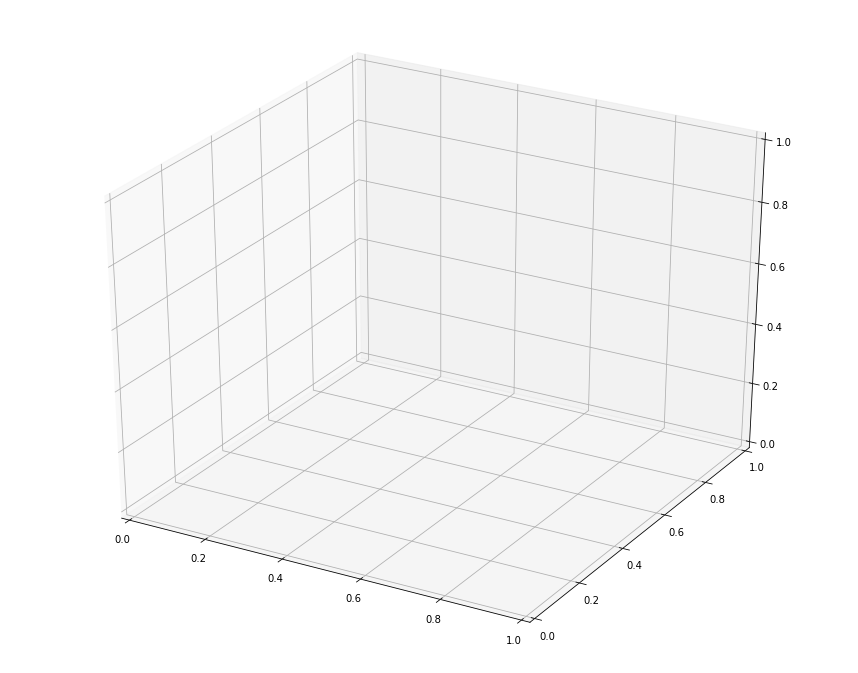

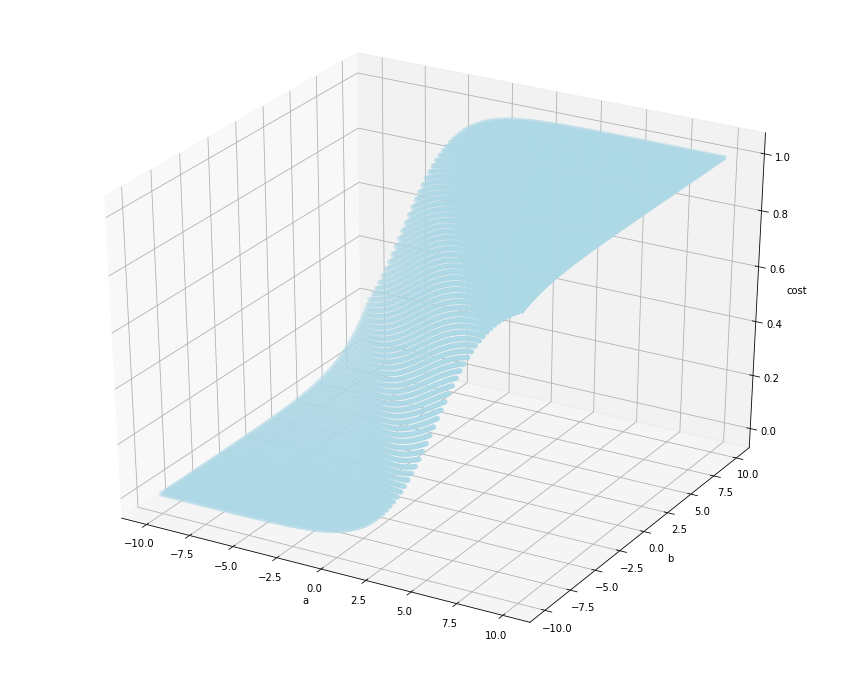

In [292]:
#random initial values
nn.weights =  [[], [[-0.5165693483520402, 0.6381374990633439], [-0.5919999002100662, 0.2758633810748421]], [[0.8569660716811944, -0.19179130414197276]]]
nn.bias =  [[], [0.6160159801693461, -0.25006252942949336], [0.8104689775729195]]


import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
 
 
va = [];vb = [];vc = []
for aa in range(-50,51):
    a = 1.0 * aa / 5
    for bb in range(-50, 51):
        b = 1.0 * bb / 5
        nn.weights[2][0] = [a,b]
        c = nn.test([0,0])
        va.append(a);vb.append(b);vc.append(c)
ax.scatter(va, vb, vc, color='lightblue', depthshade=True)

# print vc
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('cost')
plt.show()